# Superradiant-scattered light around a Kerr black hole

In [18]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from scipy.spatial import distance

In [19]:
def calculate_christoffel(jacob, g_inv, dims):
    # based on https://github.com/AndreaAntoniali/Riemann-tensor-calculator/blob/main/Riemann_Calculations.ipynb
    gamma = np.zeros((dims, dims, dims))
    for beta in range(dims):
        for mu in range(dims):
            for nu in range(dims):
                for alpha in range(dims):
                    gamma[beta,mu,nu] = 1/2 * g_inv[alpha][beta] * (jacob[alpha][mu][nu] + jacob[alpha][nu][mu] - jacob[mu][nu][alpha])
    return gamma

def christoffel_at_point_4d(metric, inverse_metric, t, r, theta, phi, dims):
    coord = torch.tensor([t, r, theta, phi], requires_grad=True)
    g_inv = inverse_metric(coord)
    jacobian = torch.autograd.functional.jacobian(metric, coord, create_graph=True)
    return calculate_christoffel(jacobian, g_inv, dims)

In [20]:
def kerr_metric(coords, M=2e30, a=0.97):
    t = coords[0]
    r = coords[1]
    theta = coords[2]
    phi = coords[3]
    sigma = r ** 2 + a ** 2 * torch.cos(theta) ** 2
    delta = r ** 2 - 2 * M * r + a ** 2
    return torch.tensor([
        [-(1 - (2 * M * r) /sigma), 0., 0., -((2 * M * r * a * torch.sin(theta) ** 2) / sigma)],
        [0., sigma / delta, 0., 0.],
        [0., 0., sigma, 0.],
        [-((2 * M * r * a * torch.sin(theta) ** 2) / sigma), 0., 0., (r ** 2 + a ** 2 + (2 * M * r * a ** 2)/sigma * torch.sin(theta) ** 2) * torch.sin(theta) ** 2]
    ])

def kerr_inverse_metric(coords, M=2e30, a=0.97):
    # Based off https://www.roma1.infn.it/teongrav/onde19_20/kerr.pdf
    t = coords[0]
    r = coords[1]
    theta = coords[2]
    phi = coords[3]
    sigma = r ** 2 + a ** 2 * torch.cos(theta) ** 2
    delta = r ** 2 - 2 * M * r + a ** 2
    return torch.tensor([
        [-1 / delta * (r ** 2 + a ** 2 + (2 * M * r * a ** 2) / sigma * torch.sin(theta) ** 2), 0., 0., -(2 * M * r * a) / (sigma * delta)],
        [0., delta / sigma, 0., 0.],
        [0., 0., 1 / sigma, 0.],
        [-(2 * M * r * a) / (sigma * delta), 0., 0., (delta - a ** 2 * torch.sin(theta) ** 2) / (sigma * delta * torch.sin(theta) ** 2)]
    ])

def kerr_d_dt(X, t):
    # Array of derivatives
    f = np.zeros(X.shape)
    x = X[:4]
    velocities = X[4:]
    f[:4] = velocities
    t, r, theta, phi = x
    Gamma = christoffel_at_point_4d(kerr_metric, kerr_inverse_metric, t, r, theta, phi, 4)

    for i in range(4):
        Gamma[:,:,i] += np.transpose(Gamma[:,:,i])
        Gamma[:,:,i] -= np.diag(np.diag(Gamma[:,:,i]))/2
        f[4 + i] = -velocities @ Gamma[:,:,i] @ velocities
    return f

In [21]:
def point_xyz_from_spherical(u):
    r = u[1]
    theta = u[2]
    phi = u[3]
    # Convert spherical to cartesian
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    point = [x, y, z]
    return point

In [22]:
def point_xyzt_from_spherical(u):
    t = u[0]
    r = u[1]
    theta = u[2]
    phi = u[3]
    # Convert spherical to cartesian
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    point = [t, x, y, z]
    return point

In [23]:
def kerr_intersection_rk4(mesh, f, u0, t0=0, tf=100000, h=0.01, debug=False):
    u = u0
    t = t0
    u_array = [u0]
    
    while t < tf:
        k1 = h * f(u, t)    
        k2 = h * f(u + 0.5 * k1, t + 0.5*h)
        k3 = h * f(u + 0.5 * k2, t + 0.5*h)
        k4 = h * f(u + k3, t + h)
        u = u + (k1 + 2*(k2 + k3 ) + k4) / 6
        u_array.append(u)
        point = point_xyz_from_spherical(u)
        if debug:
            print(point)
        if is_on_surface(mesh, np.array(point)):
            if debug:
                print("Found point on surface")
            return u_array, u

In [24]:
def txyz_to_spherical(t, arr):
    """
    Converts a [x, y, z] array
    to [r, theta, phi] array
    """
    x = arr[0]
    y = arr[1]
    z = arr[2]
    r = (x ** 2 + y ** 2 + z ** 2) ** (1/2)
    theta = np.arccos(z / r)
    phi = np.arctan(y / x)
    return [t, r, theta, phi]

In [25]:
def is_on_surface(mesh, point, delta=5):
    # Checks if point is on the surface of the mesh
    # with tolerance of 5 meters
    a = mesh.ray.contains_points([point - delta])
    b = mesh.ray.contains_points([point + delta])
    return a == True and b == False

The initial velocity is determined by the conversion of cartesian 3-velocity of light to spherical coordinates, resulting in:

$$
\frac{dr}{d\lambda} = c
$$

$$
\frac{d\theta}{d\lambda} = \theta_0
$$

$$
\frac{d\phi}{d\lambda} = \phi_0
$$

Conversions between spherical and cartesian velocities are given as follows - they are used to obtain a cartesian vector for use in the outgoing ray vector calculations:

$$
v_r = \frac{xx' + y y' + zz'}{r}
$$

$$
v_\theta = \frac{z r' - rz'}{r^2 \sqrt{1 - \left(\frac{z}{r}\right)^2}}
$$

$$
v_\phi = \frac{xy' - y x'}{x^2 + y^2}
$$

$$
v_x = r \cos \phi \cos \theta \theta' + \sin \theta \cos \phi r' - r \sin \phi \sin \theta \phi'
$$

$$
v_y = r \sin \phi \cos \theta \theta' + r \sin \theta \cos \phi \phi' + \sin \phi \sin \theta r'
$$

$$
v_z = \cos \theta r' - r \sin \theta \theta'
$$

A 1 solar mass black hole will be simulated, with an outer ergosphere radius of $2964.4\mathrm{\ m}$, as given by:

$$
r_E = \frac{r_s + \sqrt{{r_s}^2 - 4a^2 \cos^2 \theta}}{2}
$$

The reactor cavity will be just enclosing of the ergosphere, with a radius of $r_E + 100\mathrm{\ m}$. 

The reflected light ray vector $\vec v_o$ will be found from the incoming light ray vector $\vec v_i$ and the normal vector $\vec N$ from:

$$
\vec v_o = \vec v_i - \frac{2 \vec v_i \cdot \vec N}{\vec N \cdot \vec N}\vec N
$$

In [26]:
def schwarzschild_radius(M, G=6.67e-11, c=3e8):
    return (2 * G * M) / (c ** 2)

In [27]:
def outer_ergosphere(M=2e30, theta=np.pi/2, a=0.97):
    r_s = schwarzschild_radius(M)
    return (r_s + (r_s ** 2 - 4 * a * (np.cos(theta)) ** 2) ** (1/2)) / 2

In [41]:
def cartesian_velocity_to_spherical(x, y, z, v_x, v_y, v_z):
    r = (x ** 2 + y ** 2 + z ** 2) ** (1/2)
    v_r = (x * v_x + y * v_y + z * v_z) / r
    v_theta = (z * v_r - r * v_z) / (r ** 2 * (1 - (z / r) ** 2) ** (1/2))
    v_phi = (x * v_y - y * v_x) / (x ** 2 + y ** 2)
    return np.array([v_r, v_theta, v_phi])

In [42]:
def spherical_velocity_to_cartesian(r, theta, phi, v_r, v_theta, v_phi):
    v_x = r * np.cos(phi) * np.cos(theta) * v_theta + np.sin(theta) + np.cos(phi) * v_r - r * np.sin(phi) * np.sin(theta) * v_phi
    v_y = r * np.sin(phi) * np.cos(theta) * v_theta + r * np.sin(theta) * np.cos(phi) * v_phi + np.sin(phi) * np.sin(theta) * v_r
    v_z = np.cos(theta) * v_r - r * np.sin(theta) * v_theta
    return np.array([v_x, v_y, v_z])

In [30]:
# thanks to: https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points
def closest_vertex(point, mesh):
    closest_index = distance.cdist([point], mesh.vertices).argmin()
    return mesh.vertices[closest_index]

In [31]:
def get_normal_from_point(mesh, point):
    vertex = closest_vertex(point, mesh)
    vertices = mesh.vertices.tolist()
    idx = vertices.index(vertex.tolist())
    return mesh.vertex_normals[idx]

In [32]:
def outgoing_vector(incoming, normal):
    return incoming - (((2 * incoming).dot(normal)) / (normal.dot(normal))) * normal

In [33]:
# Create icosphere for reactor cavity
mesh = trimesh.creation.icosphere(subdivisions=1, radius=outer_ergosphere() + 100)

In [34]:
# samples
N = 150
# initial ray position
ray_origin = [0.01, 0.01, outer_ergosphere() + 99]
c = 3e8
theta_0 = np.pi
phi_0 = 0
ray_v = np.array([1.0, c, theta_0, phi_0])
# Initial condition uses ray origin converted to spherical coords
# and ray initial velocity
ray_origin_spherical = txyz_to_spherical(0.0, ray_origin)
ray_initial = np.concatenate((ray_origin_spherical, ray_v))

In [35]:
ray_positions_spherical = np.array((N + 1) * [ray_initial])

In [36]:
path = [np.array([0, *ray_origin])]

In [43]:
for i in range(1, N):
    # Find the point of intersection accounting for curving
    # of straight path in Kerr spacetime
    geodesic, intersection_point = kerr_intersection_rk4(mesh, kerr_d_dt, ray_positions_spherical[i - 1], h=1e-12, debug=True)
    # Intersection point is next ray position
    # 4-vector of ray velocity is computed by doing vector calculations
    # based on last set of velocity vectors
    tau, r, theta, phi, v_tau, v_r, v_theta, v_phi = intersection_point
    v_cartesian_incoming = spherical_velocity_to_cartesian(r, theta, phi, v_r, v_theta, v_phi)
    position_cartesian = point_xyz_from_spherical(intersection_point)
    intersection_normal = get_normal_from_point(mesh, position_cartesian)
    v_cartesian_outgoing = outgoing_vector(v_cartesian_incoming, intersection_normal)
    v_spherical_outgoing = cartesian_velocity_to_spherical(*position_cartesian, *v_cartesian_outgoing)
    # dr/dt = c, dtheta/dt and dphi/dt are computed from
    # reflected_ray() after conversion back to spherical
    next_starting_point = [tau, r, theta, phi, v_tau, c, v_spherical_outgoing[1], v_spherical_outgoing[2]]
    ray_positions_spherical[i] = next_starting_point
    for point in geodesic:
        path.append(point[:4]) # disregard velocity components

[0.009999978061561747, 0.009999978061561745, 3063.4447444444445]
[0.009999985846113198, 0.009999985846113196, 3063.4450444444446]
Found point on surface
[0.010212680870053559, 0.009998303653931907, 3063.4453444437486]
Found point on surface
[0.010642431765782535, 0.009988100561071583, 3063.445644442319]
Found point on surface
[0.011297486550741557, 0.009955453780482938, 3063.4459444400795]
Found point on surface
[0.012188972612321955, 0.009878903464230026, 3063.44624443691]
[0.013092522402008974, 0.009745098965117079, 3063.4465444336106]
[0.014004903807486417, 0.009552950393144927, 3063.4468444301806]
Found point on surface
[0.01517357465694943, 0.009285159117982823, 3063.4471444254386]
Found point on surface
[0.01660719423056118, 0.008904226892295053, 3063.4474444191337]
[0.018043664448548918, 0.008388520422343997, 3063.447744412465]
Found point on surface
[0.019746237708272538, 0.007714060211995825, 3063.4480444037367]
[0.021430474035227225, 0.0068572282543826555, 3063.4483443944555]

[0.10247976314557843, 0.4323398632221747, 3063.4783122555837]
[0.12686685300824765, 0.4333412572859674, 3063.478611201233]
[0.15163042397639337, 0.4329573204066376, 3063.478910129908]
[0.17669141067801072, 0.43115189199467574, 3063.479209041609]
[0.20196802184566834, 0.42789333635633603, 3063.4795079363366]
[0.22737599958007618, 0.42315472743451354, 3063.479806814091]
[0.25282889040006556, 0.41691401869500666, 3063.480105674871]
Found point on surface
[0.2783953391366047, 0.4091450480984937, 3063.480404505635]
[0.3038301128612826, 0.3998263713912734, 3063.4807033190427]
Found point on surface
[0.3292231454399032, 0.3889402881998334, 3063.4810020968157]
Found point on surface
[0.3544941157811841, 0.3764625556697801, 3063.4813008355577]
Found point on surface
[0.3795592935893045, 0.36237264218693277, 3063.481599531645]
[0.4041134391507822, 0.346667235294595, 3063.481898208538]
[0.4280548907443281, 0.3293616678428459, 3063.4821968662377]
Found point on surface
[0.45152086857782364, 0.3104

[0.11728754225818527, 1.7448336536261908, 3063.512345344059]
Found point on surface
[0.21116660558193268, 1.751405231458227, 3063.51263656158]
[0.3060629129473398, 1.7528882432622486, 3063.512927702506]
[0.401698763868028, 1.7491938685127046, 3063.5132187668382]
Found point on surface
[0.49785757770504285, 1.7402451610861018, 3063.5135097454995]
[0.5941823133650801, 1.725980103431444, 3063.5138006474126]
[0.6903776235013268, 1.7063567843685044, 3063.5140914725775]
[0.7861442313917375, 1.681349765809028, 3063.5143822209943]
Found point on surface
[0.8813076700846758, 1.65094352169163, 3063.514672859591]
[0.9754363180708774, 1.6151387620084208, 3063.514963420896]
[1.0682234856016637, 1.573960896141446, 3063.5152539049095]
[1.1593623333672085, 1.5274527689150035, 3063.5155443116328]
Found point on surface
[1.2487289941158752, 1.4756646668530615, 3063.515834571685]
Found point on surface
[1.3360318081591582, 1.4186528873410786, 3063.516124673527]
Found point on surface
[1.4209794653148813,

[0.09910320836575572, 3.968306266830201, 3063.54537273957]
[0.31210534399222617, 3.980838223275251, 3063.5456421859067]
Found point on surface
[0.5267416805915447, 3.9818787563139932, 3063.545911448492]
Found point on surface
[0.7424054373006104, 3.9712888385843983, 3063.5461805228833]
[0.958424247744208, 3.9489638913277982, 3063.5464494167154]
Found point on surface
[1.1742279569407483, 3.9148335774936043, 3063.5467181068025]
[1.3890982197430983, 3.8688612955050434, 3063.546986616064]
Found point on surface


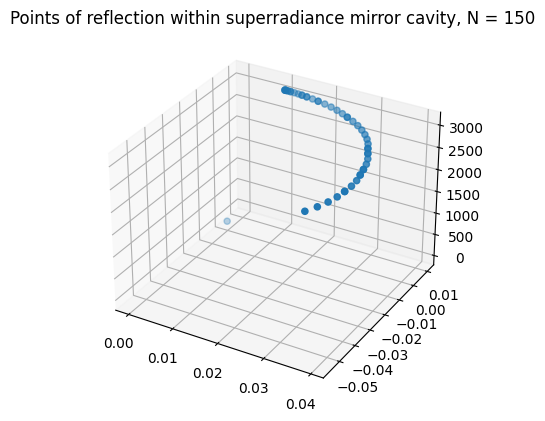

In [58]:
x_sol = np.array(path)

t = x_sol[:,0]
r = x_sol[:,1]
theta = x_sol[:,2]
phi = x_sol[:,3]

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter(x[:50], y[:50], z[:50]) # only show 30 or it's too much to fit on one graph
ax.set_title("Points of reflection within superradiance mirror cavity, N = 150")
plt.show()

Note that as the reflections after the first few bounces are extremely closely packed together, they are somewhat difficult to see in the above plot, but they are present.

The energy of the light ray can be found as the following line integral:

$$
E = h \int_C \frac{Mrac}{\pi \Sigma^2} \cdot dr
$$

Where $a = 0.97$ and $\Sigma = r^2 + a^2 \cos \theta$.

In [200]:
E = []

In [201]:
def integrand(i, M=2e30, a=0.97, c=3e8):
    sigma = r[i] ** 2 + a ** 2 * np.cos(theta[i])
    return (M * r[i] * a * c) / (np.pi * sigma ** 2)

In [202]:
def trajectory_derivative(i, t=t, r=r, theta=theta, phi=phi, delta=5):
    # computes derivatives via difference quotient
    dr_dt = (r[i + delta] - r[i]) / (t[i + delta] - t[i])
    dtheta_dt = (theta[i + delta] - theta[i]) / (t[i + delta] - t[i])
    dphi_dt = (phi[i + delta] - phi[i]) / (t[i + delta] - t[i])
    return (dr_dt ** 2 + dtheta_dt ** 2 + dphi_dt ** 2) ** (1/2)

In [203]:
def quad_line_integral(tmax, t_span=t, f=integrand, trajectory_derivative=trajectory_derivative, h=6.626e-34):
    quad_sum = 0
    i = 0
    while t_span[i] < tmax:
        delta = t_span[i + 1] - t_span[i]
        quad_sum += h * integrand(i) * trajectory_derivative(i) * delta
        i += 1
    return quad_sum

In [204]:
for t_el in t:
    try:
        E.append(quad_line_integral(t_el))
    except IndexError:
        print("Done")

Done
Done
Done
Done


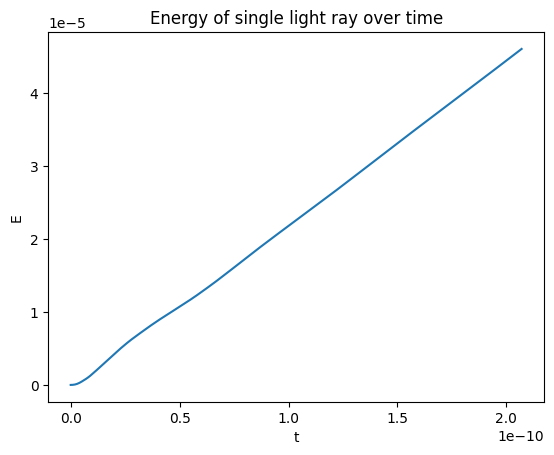

In [207]:
fig = plt.figure()
ax = plt.axes()

ax.plot(t[:300], E[:300])
ax.set_xlabel("t")
ax.set_ylabel("E")
plt.title("Energy of single light ray over time")
plt.show()